In [1]:
# GPU scaling lidDrivenCavity
# comparison OF + DIC vs GKO and var. preconditioner
import matplotlib.pyplot as plt
import numpy as np
from import_benchmark_data import import_results
from helpers import idx_query, idx_keep_only, compute_speedup

plt.rcParams.update({'font.size': 18})

Owls Version: 0.10.0-26-g31283c0
Warning no matplotlib support


In [2]:
def line_plot(df, x, columns, facet, properties, fig, axes, kind="line", x_label=None, facet_is_legend=False):
    lines = set(df.index.get_level_values(facet))
    for i, q in enumerate(columns):
        for line in lines:
            sel = df[df.index.get_level_values(facet) == line]
            sel = idx_keep_only(sel,  keep=[x])
            ax = axes[i]
            legends = properties.get("legends")
            legend = line  if facet_is_legend else False
            f = sel.sort_index().plot(
                legend=True,
                label=legend,
                lw=3,
                ms=10,
                kind=kind,
                ax=ax, 
                marker=properties["marker"](line),
                #color=properties["color"](line),
            )
            if x_label:
                ax.set_xlabel(x_label[i])
            if legends:
                plt.legend(legends)

# Speedup vs Single Node over n-Nodes

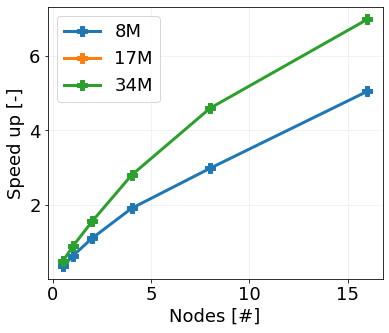

In [4]:
path = "../../results/f0824b3b/motorcycle/"

df = import_results(
    path=path,
    case="scaling",        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False,
    resolution_map={
        "Small": 8.678,
        "Medium": 17.356,
        "Large": 34.713,
        "Huge": 68,
        "Giant": 128
    }
    )["raw"]


columns = ["linear_solve_p"] #, "number_iterations_p" ]

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(6 * len(columns), 5),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "horeka", True),
           # ("resolution", b)
        ])

gko_precond = "BJ"
a = df.index.get_level_values("preconditioner_p") == gko_precond 
b = df.index.get_level_values("preconditioner_p") == "DIC"
df = df[np.logical_or(a,b,b)] 

df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
df["nodes"] = df.index.get_level_values('mpi_ranks')
mask = df.index.get_level_values("executor_p") == "CUDA"
df.loc[mask,"nodes"] = df.loc[mask, "nodes"]/4
mask = df.index.get_level_values("executor_p") == "DefaultOF"
df.loc[mask,"nodes"] = df.loc[mask, "nodes"]/76
df = df.set_index("nodes", append=True)


of_data = compute_speedup(df,
        [("nodes", 1),
         ("preconditioner_p", "DIC"),
         ("executor_p", "DefaultOF")
        ],
        drop_indices=["node", "mpiRank_of", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks"],
        )


of_data = idx_query(of_data, [
        ("preconditioner_p", "DIC", False),    
#        ("mpi_ranks", 76, False),
    ]).sort_index()

#of_data["linear_solve_p"] = of_data["linear_solve_p"] / of_data[ "number_iterations_p" ]
#of_data = of_data[np.logical_not(np.logical_and(
#    of_data.index.get_level_values("resolution") == 34.713,
#    of_data.index.get_level_values("mpi_ranks") == 5
#))]
                    
line_plot(of_data["linear_solve_p"], 
    x="nodes", 
    columns=columns, 
    facet="resolution",
    #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
    fig=fig,
    axes=axes,
    facet_is_legend=True,
    properties={
    "legends": ["8M", "17M", "34M"],
    "marker": lambda x: "P",
    "color": lambda x: "black",
    "title": lambda x: ["Linear Solve P"][x]
})

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")

plt.savefig(path + "/linear_solve_multi_gpu_{}_vs_single_node.png".format(gko_precond), bbox_inches='tight')

# Speedup vs DefaultOF over n-Nodes

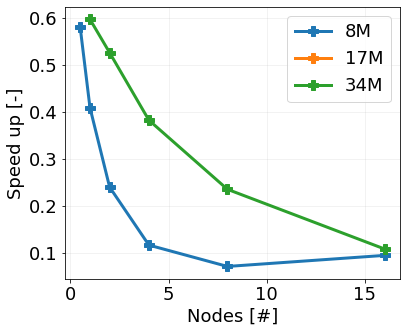

In [5]:
path = "../../results/f0824b3b/motorcycle/"

df = import_results(
    path=path,
    case="scaling",        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False,
    resolution_map={
        "Small": 8.678,
        "Medium": 17.356,
        "Large": 34.713,
        "Huge": 68,
        "Giant": 128
    }
    )["raw"]


columns = ["linear_solve_p"] #, "number_iterations_p" ]

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(6 * len(columns), 5),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "horeka", True),
           # ("resolution", 300)
        ])

gko_precond = "Multigrid"
a = df.index.get_level_values("preconditioner_p") == gko_precond 
b = df.index.get_level_values("preconditioner_p") == "DIC"
df = df[np.logical_or(a,b,b)] 

df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
df["nodes"] = df.index.get_level_values('mpi_ranks')
mask = df.index.get_level_values("executor_p") == "CUDA"
df.loc[mask,"nodes"] = df.loc[mask, "nodes"]/4
mask = df.index.get_level_values("executor_p") == "DefaultOF"
df.loc[mask,"nodes"] = df.loc[mask, "nodes"]/76
df = df.set_index("nodes", append=True)


of_data = compute_speedup(df,
        [#("mpi_ranks", 76),
         ("preconditioner_p", "DIC"),
         ("executor_p", "DefaultOF")
        ],
        drop_indices=["node", "mpiRank_of", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks"],
        )


of_data = idx_query(of_data, [
        ("preconditioner_p", "DIC", False),    
#        ("mpi_ranks", 76, False),
    ]).sort_index()

#of_data["linear_solve_p"] = of_data["linear_solve_p"] / of_data[ "number_iterations_p" ]
#of_data = of_data[np.logical_not(np.logical_and(
#    of_data.index.get_level_values("resolution") == 34.713,
#    of_data.index.get_level_values("mpi_ranks") == 5
#))]
                    
line_plot(of_data["linear_solve_p"], 
    x="nodes", 
    columns=columns, 
    facet="resolution",
    #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
    fig=fig,
    axes=axes,
    facet_is_legend=True,
    properties={
    "legends": ["8M", "17M", "34M"],
    "marker": lambda x: "P",
    "color": lambda x: "black",
    "title": lambda x: ["Linear Solve P"][x]
})

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")

plt.savefig(path + "/linear_solve_multi_gpu_{}.png".format(gko_precond), bbox_inches='tight')